In [1]:
import sys
sys.path.append('../..') # Asegúrate de que Python pueda encontrar el paquete src

# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from src.physics.crystals import KTPCrystal

In [2]:
# Fundamental Wavelength: 795 nm = 0.795 um
lambda_fundamental_um = 0.795
lambda_shg_um_example = lambda_fundamental_um / 2.0 # 397.5 nm = 0.3975 um

# Instancia del cristal
ktp_crystal = KTPCrystal()

# --- Calcular Propiedades Ópticas en la fundamental y SHG ---
# Propiedades en la fundamental (795 nm)
axis_example = 'nz'
n_fundamental = ktp_crystal.refractive_index(lambda_fundamental_um, axis=axis_example)
dn_dlambda_fundamental = ktp_crystal.refractive_index_derivative_analytical(lambda_fundamental_um, axis=axis_example)
n_g_fundamental = ktp_crystal.group_index(lambda_fundamental_um, axis=axis_example)
v_g_fundamental = ktp_crystal.group_velocity(lambda_fundamental_um, axis=axis_example)
print(f"--- Propiedades en {lambda_fundamental_um} um ({axis_example}) ---")
print(f"Phase Index (n): {n_fundamental:.6f}")
print(f"dn/dlambda : {dn_dlambda_fundamental:.6f} um^-1")
print(f"Group Index (n_g): {n_g_fundamental:.6f}")
print(f"Group Velocity (v_g): {v_g_fundamental:.2f} m/s")

# Propiedades en el segundo armónico (397.5 nm)
n_shg = ktp_crystal.refractive_index(lambda_shg_um_example, axis=axis_example)
dn_dlambda_shg = ktp_crystal.refractive_index_derivative_analytical(lambda_shg_um_example, axis=axis_example)
n_g_shg = ktp_crystal.group_index(lambda_shg_um_example, axis=axis_example)
v_g_shg = ktp_crystal.group_velocity(lambda_shg_um_example, axis=axis_example)
print(f"\n--- Propiedades en {lambda_shg_um_example} um ({axis_example}) ---")
print(f"Phase Index (n): {n_shg:.6f}")
print(f"dn/dlambda : {dn_dlambda_shg:.6f} um^-1")
print(f"Group Index (n_g): {n_g_shg:.6f}")
print(f"Group Velocity (v_g): {v_g_shg:.2f} m/s")

--- Propiedades en 0.795 um (nz) ---
Phase Index (n): 1.844375
dn/dlambda : -0.081369 um^-1
Group Index (n_g): 1.909063
Group Velocity (v_g): 157036431.46 m/s

--- Propiedades en 0.3975 um (nz) ---
Phase Index (n): 1.967774
dn/dlambda : -1.121492 um^-1
Group Index (n_g): 2.413567
Group Velocity (v_g): 124211343.09 m/s


### Phase mismatch
---

In [3]:
SPEED_OF_LIGHT_M_PER_S = 299792458.0  # Speed of light in vacuum (m/s)

In [4]:
def phase_mismatch(omega, omega_0):
    """
    
    Parameters
    ----------
    omega : float, array
        The second-harmonic frequencies. Units Hz
    omega_0 : float
        The fundamental frequency. Units Hz.
    
    Returns
    -------
    float, array
        The phase mismatch (delta_k) in m^-1.
    
    Notes
    -----
    - The phase mismatch is calculated using:  
    delta_k = (1/v_g(2*omega_0) - 1/v_g(omega_0)) * (omega - 2*omega_0)
    
    where:
        - omega are the second-harmonic frequencies, 
        - omega_0 is the fundamental central frequency, and
        - 2*omega_0 is the second-harmonic central frequency.

    - The phase mismatch is a function of the second-harmonic frequency only.
    """
    
    c = SPEED_OF_LIGHT_M_PER_S
    
    omega_SHG_0 = 2 * omega_0  # second harmonic central frecuency
    
    lambda_0 = (2 * np.pi * c / omega_0)
    lambda_shg_0 = (2 * np.pi * c / omega_SHG_0)

    # Get group velocities at omega_0 and 2*omega_0 using KTPCrystal
    # group_velocity method expects wavelength in (um) and returns velocity in m/s
    v_g_2omega0 = ktp_crystal.group_velocity(lambda_shg_0, axis='nz')  # is evaluated at 2*omega_0 => lambda_0 / 2
    v_g_omega0 = ktp_crystal.group_velocity(lambda_0, axis='nz')       # is evaluated at omega_0 => lambda_0
    
    # Calculate the Group Velocity Mismatch (GVM) term in (s/m)
    gvm_term = (1 / v_g_2omega0) - (1 / v_g_omega0)
    
    #  Calculate the material phase mismatch Delta k_material in m^-1
    delta_k_material = gvm_term * (omega - omega_SHG_0)

        
    return delta_k_material

Text(0.5, 1.0, 'Phase mismatch vs SHG Frequency')

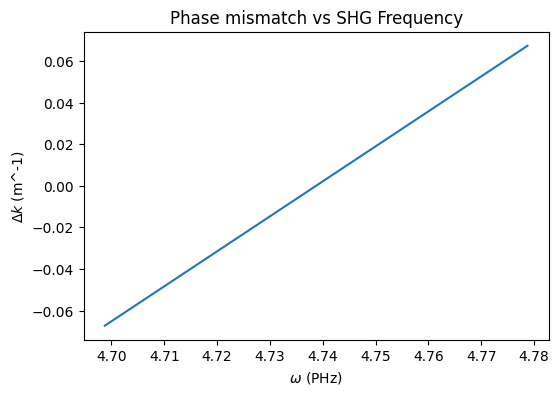

In [5]:
c = 299792458  # Speed of light in vacuum (m/s)

wavelength_fundamental = 0.795  # um | 397.5 nm -> SHG and 795 nm -> Fundamental
omega_0 = (2*np.pi*c) / wavelength_fundamental

omega_SHG = 2 * omega_0
delta = 0.04 * 1e9  # 40 GHz
omega_SHG_min = omega_SHG - delta
omega_SHG_max = omega_SHG + delta
omega_SHG_array = np.linspace(omega_SHG_min, omega_SHG_max, 100)
delta_k = phase_mismatch(omega_0=omega_0, omega=omega_SHG_array)

# Plotting the results
plt.figure(figsize=(6,4))
plt.plot(omega_SHG_array * 1e-9, delta_k)
plt.xlabel(r'$\omega$ (PHz)')
plt.ylabel(r'$\Delta k$ (m^-1)')
plt.title('Phase mismatch vs SHG Frequency')

### Phase matching
---

In [6]:
def phase_matching(delta_k, L):
    """
    Parameters
    ----------
    delta_k : float, array
        The phase mismatch in m^-1.
    L : float
        The length of the crystal in meters.
    omega : float, array
        The second-harmonic frequencies in Hz.
    
    Returns
    -------
    float, array
        The phase matching function Phi(omega).

    Notes
    -----
     Phi(omega) = sinc(delta_k * L / 2) = sin(delta_k * L / 2) / (delta_k * L / 2)
     
     where:
        - delta_k is the phase mismatch in m^-1.
        - L is the length of the crystal in meters.
        - omega is the second-harmonic frequency in Hz.
    """
    phi = np.sin(delta_k * L / 2) / (delta_k * L / 2)
    phi[delta_k == 0] = 1  # Handle the case where delta_k is zero to avoid division by zero
    
    return phi

Text(0.5, 1.0, 'Phase Matching Function vs SHG Frequency')

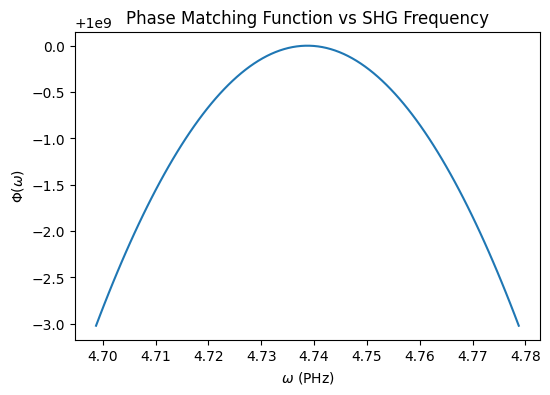

In [7]:
# test the function
L = 0.004 # (m)
phi = phase_matching(delta_k, L)

plt.figure(figsize=(6,4))
plt.plot(omega_SHG_array * 1e-9, phi* 1e9)
plt.xlabel(r'$\omega$ (PHz)')
plt.ylabel(r'$\Phi(\omega)$')
plt.title('Phase Matching Function vs SHG Frequency')

In [8]:
delta_k = np.asarray(delta_k)
arg = delta_k * L / 2
phi_ = np.sinc(arg / np.pi)
phi_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Text(0.5, 1.0, 'Phase Matching Function vs SHG Frequency')

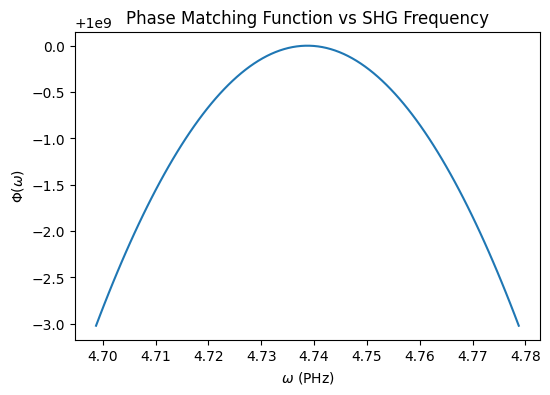

In [9]:
plt.figure(figsize=(6,4))
plt.plot(omega_SHG_array * 1e-9, phi_* 1e9)
plt.xlabel(r'$\omega$ (PHz)')
plt.ylabel(r'$\Phi(\omega)$')
plt.title('Phase Matching Function vs SHG Frequency')

### Wrap up ###
---

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Dict, List

class PhaseMatching:
    def __init__(self, crystal: KTPCrystal, lambda_0_um: float):
        """
        Initializes the PhaseMatching.

        Parameters
        ----------
        crystal : KTPCrystal
            The KTP crystal instance used for optical properties.
        lambda_0_um : float
            The fundamental wavelength in micrometers (um).
        """
        self.crystal = crystal
        self.lambda_0_um = lambda_0_um 
        self.c = KTPCrystal.SPEED_OF_LIGHT_M_PER_S
        self.omega_0 = 2 * np.pi * self.c / (self.lambda_0_um * 1e-6)  # Frecuencia fundamental (rad/s)

    def phase_mismatch(self, omega: Union[float, np.ndarray], axis: str = 'nz') -> Union[float, np.ndarray]:
        """
        Calculates the phase mismatch Delta k(omega) for second harmonic generation (SHG).

        Parameters
        ----------
        omega : float or array
            The second-harmonic frequencies in rad/s.
        axis : str, optional
            The optical axis ('nx', 'ny', 'nz'). Default is 'nz'.

        Returns
        -------
        float or array
            The phase mismatch (delta_k) in m^-1.

        Notes
        -----
        The phase mismatch is calculated using:
        delta_k = (1/v_g(2*omega_0) - 1/v_g(omega_0)) * (omega - 2*omega_0)
        where:
        - omega_0 is the fundamental frequency (stored in self.omega_0),
        - omega are the second-harmonic frequencies,
        - 2*omega_0 is the second-harmonic central frequency.
        """
        omega = np.asarray(omega)
        omega_SHG_0 = 2 * self.omega_0

        # Convert frequencies to wavelengths (in μm)
        lambda_0_um = (2 * np.pi * self.c / self.omega_0) * 1e6
        lambda_shg_0_um = (2 * np.pi * self.c / omega_SHG_0) * 1e6

        # Calculate group velocities
        v_g_2omega0 = self.crystal.group_velocity(lambda_shg_0_um, axis=axis)
        v_g_omega0 = self.crystal.group_velocity(lambda_0_um, axis=axis)

        # Calculate Group Velocity Mismatch (GVM) term in s/m
        gvm_term = (1 / v_g_2omega0) - (1 / v_g_omega0)

        # Calculate phase mismatch in m^-1
        delta_k = gvm_term * (omega - omega_SHG_0)
        return delta_k

    def phase_matching_function(self, delta_k: Union[float, np.ndarray], L: float) -> Union[float, np.ndarray]:
        """
        Calculates the phase matching function Phi for second harmonic generation (SHG).

        Parameters
        ----------
        delta_k : float or array
            The phase mismatch in m^-1.
        L : float
            The length of the crystal in meters. Must be positive.

        Returns
        -------
        float or array
            The phase matching function Phi (dimensionless).

        Notes
        -----
        Phi = sinc(delta_k * L / 2) = sin(delta_k * L / 2) / (delta_k * L / 2)

        Raises
        ------
        ValueError
            If L is not positive.
        """
        if L <= 0:
            raise ValueError("Crystal length L must be positive.")

        delta_k = np.asarray(delta_k)
        arg = delta_k * L / 2
        phi = np.sinc(arg / np.pi)  # np.sinc(x) = sin(pi*x)/(pi*x)
        return phi

### Example of use    
---

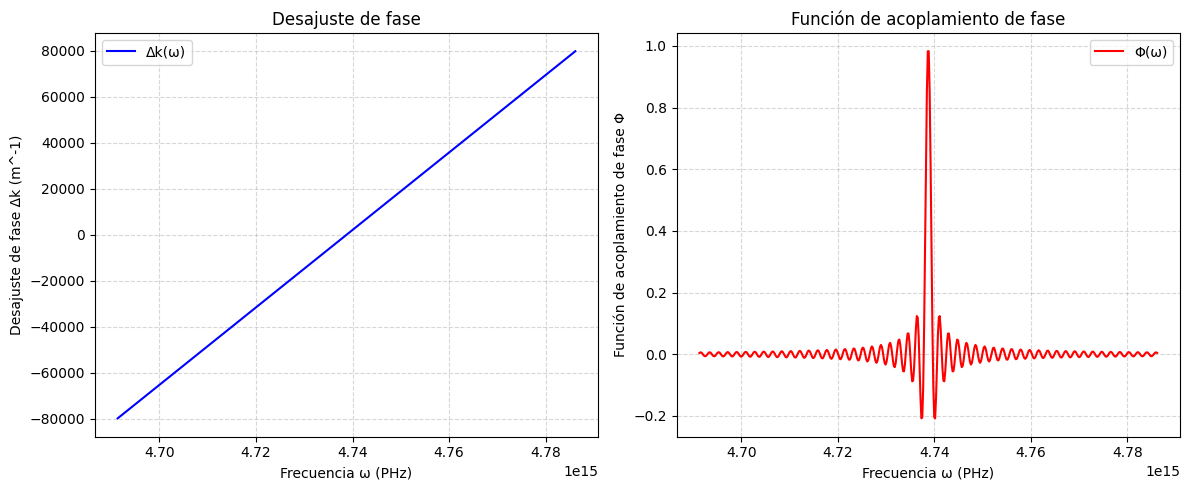

In [ ]:
# input parameters
lambda_0_um = 0.795  # um
L = 4e-3  # 4 mm

# instance of the crystal and phase matching
ktp = KTPCrystal()
phase_matching = PhaseMatching(ktp, lambda_0_um=lambda_0_um)

# Remember frequencies must be the ones for the SHG
SHG_omega_0 = 2 * phase_matching.omega_0
omega_range = np.linspace(0.99 * SHG_omega_0, 1.01 * SHG_omega_0, 500)
delta_k = phase_matching.phase_mismatch(omega_range)
phi = phase_matching.phase_matching_function(delta_k, L)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(omega_range, delta_k, label='Δk(ω)', color='b')
plt.xlabel('Frecuencia ω (PHz)')
plt.ylabel('Desajuste de fase Δk (m^-1)')
plt.title('Desajuste de fase')
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.legend()
plt.subplot(1, 2, 2)

plt.plot(omega_range, phi, label='Φ(ω)', color='r')
plt.xlabel('Frecuencia ω (PHz)')
plt.ylabel('Función de acoplamiento de fase Φ')
plt.title('Función de acoplamiento de fase')
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('phase_mismatch_and_matching.png')

plt.show()